## URL Classification - Machine Learning with Lexical Features

Outline
1. Data
2. Model Selection
3. Random Forest Parameter Tuning
4. Final Random Forest Model

### Data

Our dataset consists of 30,000 records, a balance of benign, phishing and malicious urls. 96 predictor variables are based on lexical properties of the entire url string or its components (scheme, netloc and domain, path, parameters, queries and fragments).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_pickle('capstone2_balanced_final')

In [4]:
df_model = df
#fill avg_path_token_len nans with 0s
df_model.avg_path_token_len = df_model.avg_path_token_len.fillna(0)

### 1. Model Selection

Supervised learning algorithms capable of multi-class classification were explored. Prior to any pre-processing or normalization, baseline scores are gathered for multiple classfiers.

In [5]:
# importing necessary libraries 
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 

# X -> features, y -> label 
X = df_model.drop(['category'], axis=1)
y = df_model['category']
  
# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0) 

KNeighborsClassifier
****Results****
Accuracy: 85.2000%
Log Loss: 1.5869420273401207
Confusion matrix, without normalization
[[2320   76   92]
 [ 262 2058  200]
 [ 279  201 2012]]
Normalized confusion matrix
[[0.93247588 0.03054662 0.03697749]
 [0.10396825 0.81666667 0.07936508]
 [0.11195827 0.08065811 0.80738363]]


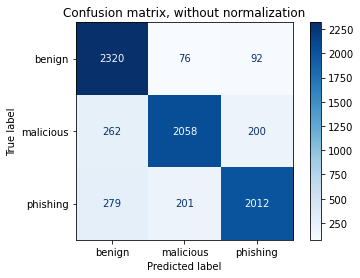

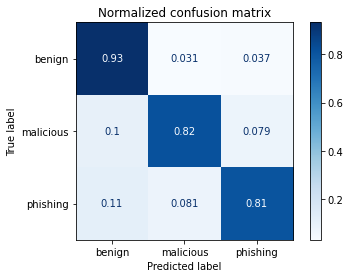

DecisionTreeClassifier
****Results****
Accuracy: 88.5333%
Log Loss: 3.960631199197908
Confusion matrix, without normalization
[[2330   48  110]
 [  76 2185  259]
 [ 126  241 2125]]
Normalized confusion matrix
[[0.93649518 0.0192926  0.04421222]
 [0.03015873 0.86706349 0.10277778]
 [0.0505618  0.09670947 0.85272873]]


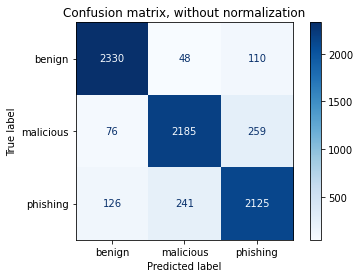

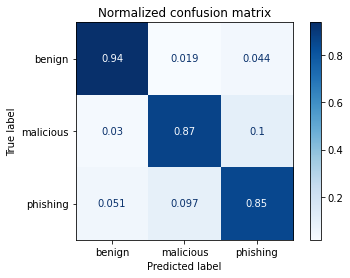

RandomForestClassifier
****Results****
Accuracy: 92.7600%
Log Loss: 0.22246252169425218
Confusion matrix, without normalization
[[2424   24   40]
 [  60 2275  185]
 [ 109  125 2258]]
Normalized confusion matrix
[[0.97427653 0.0096463  0.01607717]
 [0.02380952 0.90277778 0.0734127 ]
 [0.04373997 0.05016051 0.90609952]]


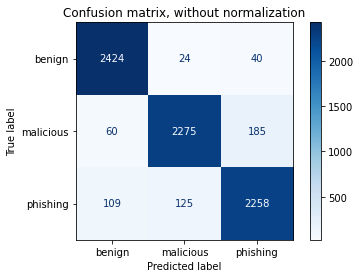

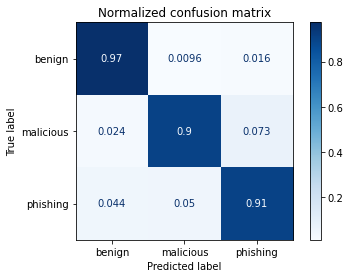

AdaBoostClassifier
****Results****
Accuracy: 84.2533%
Log Loss: 1.0158748116586196
Confusion matrix, without normalization
[[2256   60  172]
 [ 155 2071  294]
 [ 223  277 1992]]
Normalized confusion matrix
[[0.90675241 0.02411576 0.06913183]
 [0.06150794 0.8218254  0.11666667]
 [0.08948636 0.1111557  0.79935795]]


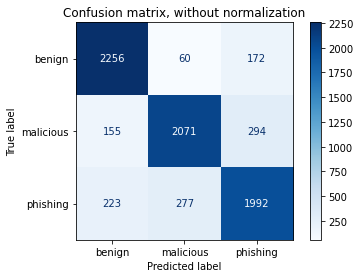

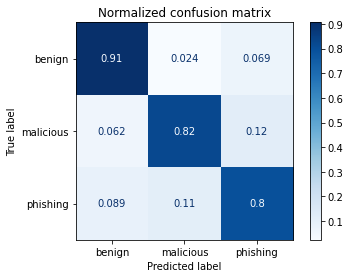

GradientBoostingClassifier
****Results****
Accuracy: 89.6667%
Log Loss: 0.29656619965502395
Confusion matrix, without normalization
[[2364   49   75]
 [ 100 2229  191]
 [ 175  185 2132]]
Normalized confusion matrix
[[0.95016077 0.01969453 0.03014469]
 [0.03968254 0.88452381 0.07579365]
 [0.07022472 0.07423756 0.85553772]]


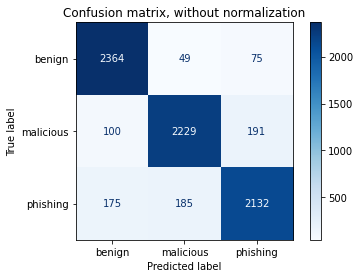

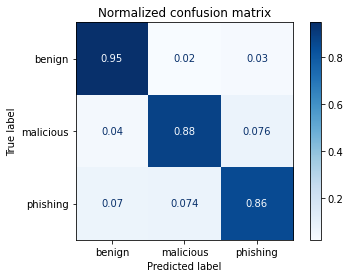

XGBClassifier
****Results****
Accuracy: 88.2933%
Log Loss: 0.3295883436295204
Confusion matrix, without normalization
[[2365   50   73]
 [ 141 2166  213]
 [ 227  174 2091]]
Normalized confusion matrix
[[0.9505627  0.02009646 0.02934084]
 [0.05595238 0.85952381 0.08452381]
 [0.09109149 0.06982343 0.83908507]]


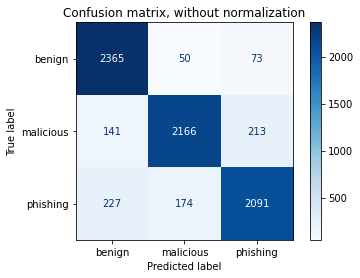

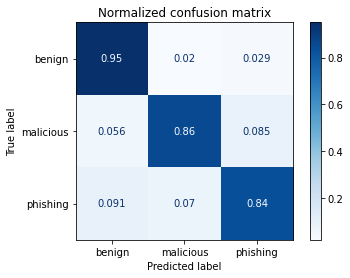

In [8]:
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost import XGBClassifier

classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(), 
    ]

# set up a df to capture accuracy and log loss
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)


for classifier in classifiers:
    name = classifier.__class__.__name__
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train, y_train)   

    #print("model score: %.3f" % pipe.score(X_test, y_test))

    print("="*30)
    print(name)
    print('****Results****')
    train_predictions = pipe.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    train_predictions = pipe.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(ll))
    
    log_entry = pd.DataFrame([[name, acc*100, ll]], columns=log_cols)
    log = log.append(log_entry)
    
    # Plot non-normalized and normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
    plt.show()
    
    
print("="*30)

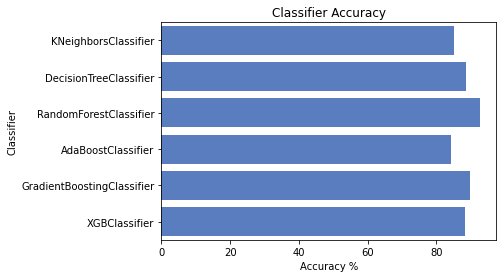

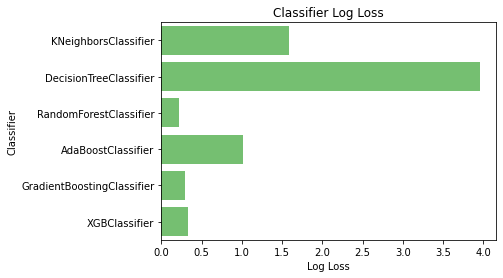

In [9]:
# Plot accuracy and log loss scores

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()

sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

### 3. Random Forest - Parameter Tuning

Based of the baseline scores, the Random Forest Classifier was selected as the algorithm to develop for a model. Using MinMax Scaler for preprocessing of numeric fields and default parameters for Random Forest Classifier. MinMax Scaler will constrain the range of all numeric values between 0 and 1. Since we bound the range, we supress the effect of outliers.

In [7]:
# set up preprocessing of numeric features and pipeline

from sklearn.preprocessing import MinMaxScaler 
from sklearn.pipeline import Pipeline

#Identifying feature type
numeric_features = df_model.select_dtypes(include=['int32', 'int64', 'float64']).columns

#Using ColumnTransformer to apply the transformations to the correct columns in the dataframe.
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

In [8]:
# split the data into train and test
X = df_model.drop(['category'], axis=1)
y = df_model['category']

feat_labels = X.columns
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0) 

In [12]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)

# identify the pipeline steps
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf)])

# Train the classifier
pipe.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)

('len_url', 0.01279209239909706)
('is_53', 0.001148439364243331)
('is_54_75', 0.001112864224876215)
('is_76', 0.0014443741200990054)
('len_tokenized_url', 0.012272621780101875)
('avg_token_len', 0.01730183958371009)
('last_slashes', 0.007271605877463769)
('loc_last_slashes', 0.013642478654834546)
('n_let', 0.017466753382659413)
('n_num', 0.00931189634059481)
('n_spec', 0.008988891705457011)
('pc_num', 0.013479183864222432)
('pc_let', 0.01949874688719739)
('pc_spec', 0.016038519067468338)
('n_dots', 0.011324818038679895)
('n_ats', 0.0007075147071179526)
('n_semicol', 0.00047582451539893205)
('num_underscores', 0.002680721777242853)
('num_question', 0.010295712739533783)
('pc_uppercase', 0.01678929412061001)
('pc_lowercase', 0.01639809095265634)
('entropy', 0.017910259304719973)
('n_masques', 0.00887031308186921)
('char_cont_rate', 0.0126802702000229)
('n_domain_suffix', 0.012775868644335008)
('len_domain', 0.014031664718843954)
('is_ip', 0.016628269870554758)
('n_domain_num', 0.0)
('n_d

Accuracy: 93.2000%
Log Loss: 0.20456319322489191
Confusion matrix, without normalization
[[1921   19   39]
 [  48 1803  138]
 [  79   85 1868]]
Normalized confusion matrix
[[0.97069227 0.00960081 0.01970692]
 [0.02413273 0.90648567 0.0693816 ]
 [0.03887795 0.04183071 0.91929134]]


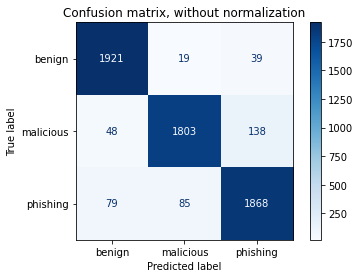

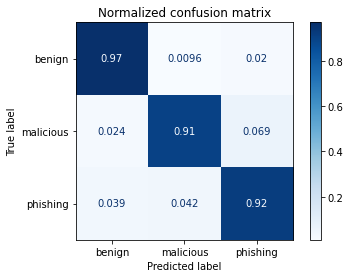

In [13]:
# predict
predictions = pipe.predict(X_test)

# print scores
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_test, predictions)))

# Plot confusion matrixes
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

RF Baseline scores
Accuracy - 93.2
Log Loss - .2045
Confusion Matrix
Benign - 97%
Phishing - 92%
Malicious - 91%

We wlll try to improve these scores with parameter tuning.

The model’s performance only increases with the number of decision trees (num_estimators). As a result, we will tune this parameter after determining other relevant parameters (like max_depth, min_samples_leaf and min_samples_split) using GridSearchCV.

#### B. Find Best Parameters for Our Classifier

In [14]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV

X = df_model.drop(['category'], axis=1)
y = df_model['category']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(random_state=0, n_jobs=-1)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', clf)])

param_grid = {'clf__bootstrap': [True], 'clf__max_depth': [None, 5, 10, 20, 30], #setting this so as not to create a tree that's too big
    'clf__max_features': [2, 3, 4, 10],
    'clf__min_samples_leaf': [1, 3, 5, 10, 20, 50],
    'clf__min_samples_split': [2, 5, 10],
    'clf__n_estimators': [300]}                
                
rf_cv=GridSearchCV(pipe, param_grid, cv=3)
rf_cv.fit(X_train,y_train)

print("Best hpyerparameters :(best parameters) ",rf_cv.best_params_)
print("accuracy :",rf_cv.best_score_)

Best hpyerparameters :(best parameters)  {'clf__bootstrap': True, 'clf__max_depth': 30, 'clf__max_features': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
accuracy : 0.9250416666666667


Next - Plugged in best parameters. Now just tuning number of estimators.

In [16]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV

X = df_model.drop(['category'], axis=1)
y = df_model['category']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(random_state=0, n_jobs=-1)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', clf)])

param_grid = {'clf__bootstrap': [True], 'clf__max_depth': [30],
    'clf__max_features': [10],
    'clf__min_samples_leaf': [1],
    'clf__min_samples_split': [2],
    'clf__n_estimators': [100, 300, 500, 800, 1200, 1500]}                
                
rf_cv=GridSearchCV(pipe, param_grid, cv=3)
rf_cv.fit(X_train,y_train)

print("Best hpyerparameters :(best parameters) ",rf_cv.best_params_)
print("accuracy :",rf_cv.best_score_)

Best hpyerparameters :(best parameters)  {'clf__bootstrap': True, 'clf__max_depth': 30, 'clf__max_features': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 800}
accuracy : 0.9239583333333333


#### C. Cross Validation

StraifiedKFold is used for validation to maintain the percent of samples for each class in our train/test subsets. 

In [13]:
# attempting stratified cross val
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import statistics

skf = StratifiedKFold(n_splits=5)
lst_accu_stratified = []

clf = RandomForestClassifier(max_depth=30, max_features=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800, n_jobs=-1)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', clf)])

for train_index, test_index in skf.split(X, y): 
    x_train_fold, x_test_fold = X.iloc[train_index], X.iloc[test_index] 
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index] 
    pipe.fit(x_train_fold, y_train_fold) 
    lst_accu_stratified.append(pipe.score(x_test_fold, y_test_fold)) 
    
#Print the output. 
print('List of possible accuracy:', lst_accu_stratified) 
print('Maximum Accuracy That can be obtained from this model is: %.2f%%' %
      (max(lst_accu_stratified) * 100))
print('Minimum Accuracy: %.2f%%' % (min(lst_accu_stratified)*100)) 
print('Overall Accuracy: %.2f%%' % (statistics.mean(lst_accu_stratified)*100))
print('Standard Deviation is: %.4f' % statistics.stdev(lst_accu_stratified)) 

List of possible accuracy: [0.9358333333333333, 0.9296666666666666, 0.931, 0.9335, 0.9268333333333333]
Maximum Accuracy That can be obtained from this model is: 93.58%
Minimum Accuracy: 92.68%
Overall Accuracy: 93.14%
Standard Deviation is: 0.0035


Our accuracy scores remain stable across all folds. Our model should predict well on url samples not included in our training/test sets.

### Final Random Forest Classifier Model

Using our tuned parameters, we train/predict, evaluate scores and look at feature importance.

In [6]:
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier

In [7]:
from sklearn.preprocessing import MinMaxScaler 

#Identifying feature type
numeric_features = df_model.select_dtypes(include=['int32', 'int64', 'float64']).columns

#Using ColumnTransformer to apply the transformations to the correct columns in the dataframe.
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

In [38]:
# X -> features, y -> label 
X = df_model.drop(['category'], axis=1)
y = df_model['category']

feat_labels = X.columns

# dividing X, y into train and test data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0) 

('len_url', 0.012239194065447555)
('is_53', 0.0010714743437520882)
('is_54_75', 0.0010814049079849119)
('is_76', 0.001324551668322829)
('len_tokenized_url', 0.012347065735921963)
('avg_token_len', 0.016794901062494153)
('last_slashes', 0.007387453607301582)
('loc_last_slashes', 0.01362584251245969)
('n_let', 0.01778926505861041)
('n_num', 0.009098494398535524)
('n_spec', 0.008908793642046909)
('pc_num', 0.013888654094737163)
('pc_let', 0.017271229624847693)
('pc_spec', 0.015472113951852898)
('n_dots', 0.011610309093515687)
('n_ats', 0.0006922282421161622)
('n_semicol', 0.00043521104296325277)
('num_underscores', 0.002665472016755888)
('num_question', 0.01035465475987699)
('pc_uppercase', 0.01606273267361949)
('pc_lowercase', 0.01592589679709467)
('entropy', 0.0174958372916263)
('n_masques', 0.009932641761387197)
('char_cont_rate', 0.012645406923375116)
('n_domain_suffix', 0.012101669571382447)
('len_domain', 0.013162144264954729)
('is_ip', 0.013475536984912908)
('n_domain_num', 0.0)
('

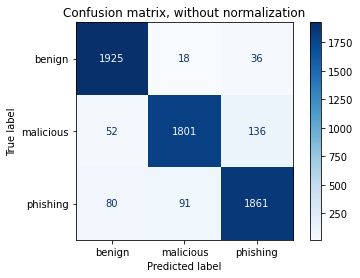

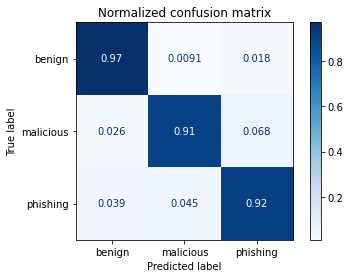

In [39]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score, classification_report

# Create a random forest classifier
clf = RandomForestClassifier(max_depth=30, max_features=10, min_samples_leaf=1, min_samples_split=2, n_estimators=800, n_jobs=-1)


pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf)])

# Train the classifier
pipe.fit(X_train, y_train)

# Print the name and gini importance of each feature
for feature in zip(feat_labels, clf.feature_importances_):
    print(feature)
      
predictions = pipe.predict(X_test)

# print scores

print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_test, predictions)))

print('Micro Precision: {:.4f}'.format(precision_score(y_test, predictions, average='micro')))
print('Micro Recall: {:.4f}'.format(recall_score(y_test, predictions, average='micro')))
print('Micro F1-score: {:.4f}\n'.format(f1_score(y_test, predictions, average='micro')))

print('Macro Precision: {:.4f}'.format(precision_score(y_test, predictions, average='macro')))
print('Macro Recall: {:.4f}'.format(recall_score(y_test, predictions, average='macro')))
print('Macro F1-score: {:.4f}\n'.format(f1_score(y_test, predictions, average='macro')))

print('Weighted Precision: {:.4f}'.format(precision_score(y_test, predictions, average='weighted')))
print('Weighted Recall: {:.4f}'.format(recall_score(y_test, predictions, average='weighted')))
print('Weighted F1-score: {:.4f}'.format(f1_score(y_test, predictions, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_test, predictions, target_names=['Benign', 'Phishing', 'Malicious'], digits=4))
    
# Plot confusion matrixes
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(pipe, X_test, y_test, cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

In [40]:
# Print the name and gini importance of each feature

feature_importance = []

for feature in zip(feat_labels, clf.feature_importances_):
    feature_importance.append(feature)
    
# take the second element for sort
def take_second(elem):
    return elem[1]

# sort list with key
sorted_feature_importance = sorted(feature_importance, key=take_second, reverse=True)[:20]

# print list
print('Feature Importance - Top 20:')
for i in sorted_feature_importance:
    print(i)

Feature Importance - Top 20:
('n_netloc_let', 0.04895700747646749)
('avg_netloc_tok_len', 0.04098839166841978)
('pc_netloc_let', 0.03379343529317082)
('n_domain_let', 0.03355638939521596)
('len_netloc', 0.03058912577876254)
('netloc_entropy', 0.029009187751187486)
('pc_domain_let', 0.02775841759734599)
('pc_domain_spec', 0.023593331291352743)
('pc_path_spec', 0.021681619295496262)
('longest_path_len', 0.021655018372416075)
('pc_netloc_num', 0.020180432597044426)
('avg_path_token_len', 0.019210717675670494)
('avg_domain_tok_len', 0.0188154955722367)
('n_domain_dots', 0.018240948880396023)
('n_let', 0.01778926505861041)
('entropy', 0.0174958372916263)
('n_domain_tok', 0.01738002288900298)
('pc_let', 0.017271229624847693)
('pc_path_uppercase', 0.01726136014710183)
('domain_entropy', 0.01695775633077101)


Feature Importance - Top 20:
('n_netloc_let', 0.04895700747646749)
('avg_netloc_tok_len', 0.04098839166841978)
('pc_netloc_let', 0.03379343529317082)
('n_domain_let', 0.03355638939521596)
('len_netloc', 0.03058912577876254)
('netloc_entropy', 0.029009187751187486)
('pc_domain_let', 0.02775841759734599)
('pc_domain_spec', 0.023593331291352743)
('pc_path_spec', 0.021681619295496262)
('longest_path_len', 0.021655018372416075)
('pc_netloc_num', 0.020180432597044426)
('avg_path_token_len', 0.019210717675670494)
('avg_domain_tok_len', 0.0188154955722367)
('n_domain_dots', 0.018240948880396023)
('n_let', 0.01778926505861041)
('entropy', 0.0174958372916263)
('n_domain_tok', 0.01738002288900298)
('pc_let', 0.017271229624847693)
('pc_path_uppercase', 0.01726136014710183)
('domain_entropy', 0.01695775633077101)


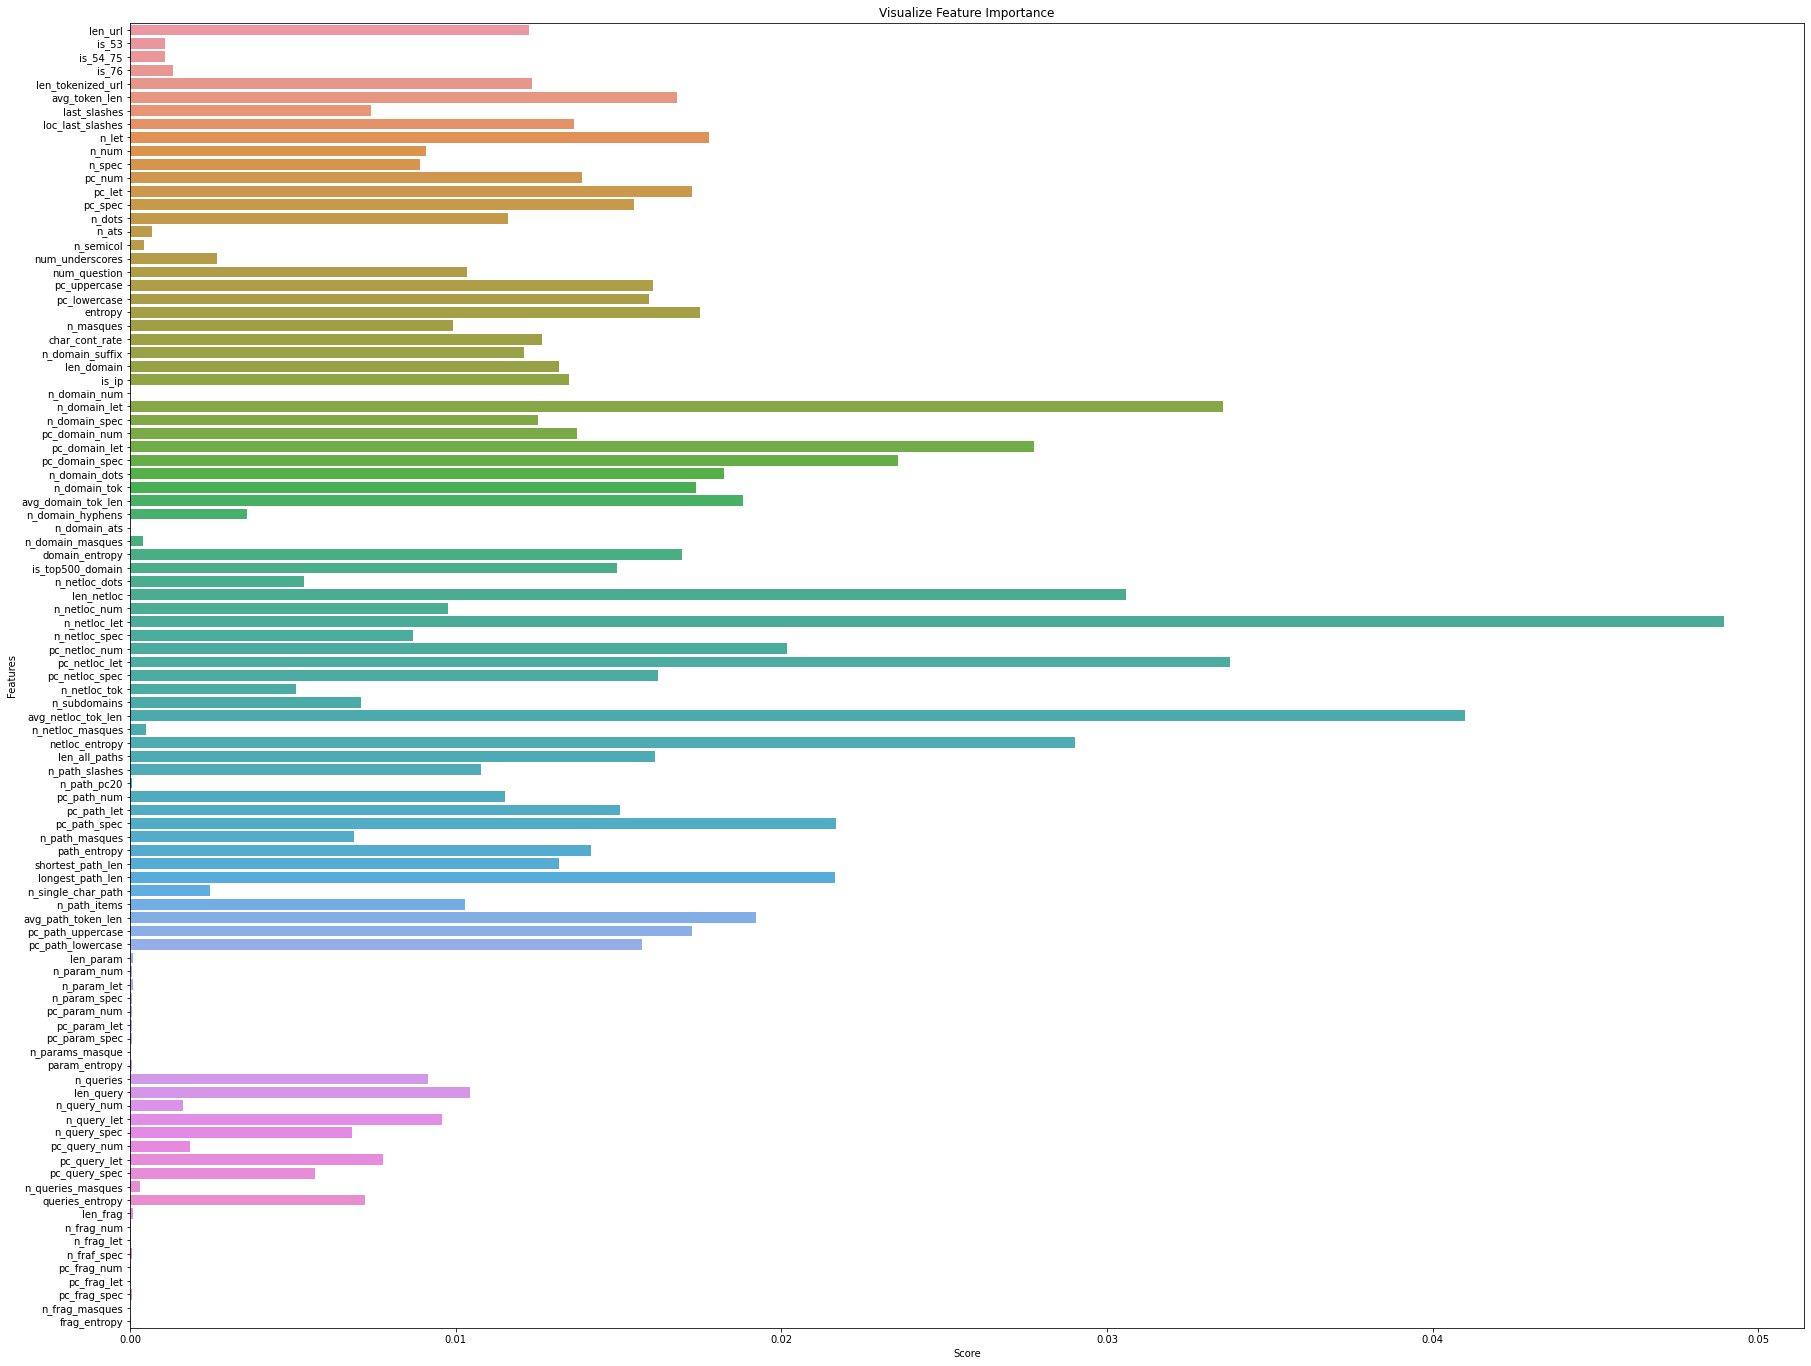

In [49]:
# Creating a seaborn bar plot

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=clf.feature_importances_, y=feat_labels)
ax.set_title("Visualize Feature Importance")
ax.set_yticklabels(feat_labels)
ax.set_xlabel("Score")
ax.set_ylabel("Features")
plt.show()

#feat_labels, clf.feature_importances_

Domain and netloc features predominate in feature importance scores for our Random Forest Classifier.